In [161]:
import pandas as pd
import numpy as np
import plotly.express as px
from functions import text_utils ,utils,classification_utils

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.multiclass import OneVsRestClassifier
import logging



logging.disable(logging.WARNING) # disable WARNING, INFO and DEBUG logging everywhere

random_state=42

# Partie 1: <u>Analyse exploiratoire, nettoyage description</u>

## 1 <u>Exploration des donnée</u>

In [162]:
df=pd.read_csv('data/Flipkart/flipkart_com-ecommerce_sample_1050.csv')

In [163]:
df.shape

(1050, 15)

In [164]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

In [165]:
df.head(3)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."


L'objet de projet étant de classer un produit en fonction de l'image fournie et de la description,nous nous intéressons uniquement aux variables catégorie,image

In [166]:
relevant_cols = ['uniq_id','product_category_tree','description','product_url']
df=df[relevant_cols]

Vérification des doublons à l'aide de la variable uniq_id

In [167]:
len(df.loc[df.duplicated(subset='uniq_id',keep='first')]) ## 0 aucun doublons

0

In [168]:
df.isnull().sum()/len(df)*100 ## aucune valeur manquante

uniq_id                  0.0
product_category_tree    0.0
description              0.0
product_url              0.0
dtype: float64

In [169]:

def get_main_category_by_depth(txt,depth=0):
    "fonction permettant de récupérer la catégorie en fonction de la profondeur, par défaut elle récupère"
    return txt.split("\"")[1].split('>>')[depth].rstrip()
    

In [170]:
df['main_category']=df['product_category_tree'].apply(lambda x:get_main_category_by_depth(x,0))
df['second_category']=df['product_category_tree'].apply(lambda x:get_main_category_by_depth(x,1))
#df['third_category']=df['product_category_tree'].apply(lambda x:get_main_category_by_depth(x,2))


In [171]:
## aucune valeur manquante
df.isnull().sum()/len(df)*100

uniq_id                  0.0
product_category_tree    0.0
description              0.0
product_url              0.0
main_category            0.0
second_category          0.0
dtype: float64

In [172]:
#df['main_category'].value_counts(normalize=True).plot.pie(autopct='%1.1f%%')
df['main_category'].value_counts(normalize=True)

Home Furnishing               0.142857
Baby Care                     0.142857
Watches                       0.142857
Home Decor & Festive Needs    0.142857
Kitchen & Dining              0.142857
Beauty and Personal Care      0.142857
Computers                     0.142857
Name: main_category, dtype: float64

In [173]:
category_percent=df['main_category'].value_counts(normalize=True).reset_index().rename(columns={'index': 'names'})
px.pie(category_percent, values='main_category', names='names', title='Diagramme à secteurs des catégories de produits').show()


Les catégories racines des produits sont égalitairement bien réparties

## 2 <u>Encodage de la variable cible (labelEncoder)</u>

In [174]:

label_target_encoder=LabelEncoder()
df['target']=label_target_encoder.fit_transform(df['main_category'])


## 3 <u>preprocessing de la variable description</u>

In [175]:
## letttre un commentaire de ce que la fonction fait
df['description_transform_bow_fct']=df['description'].apply(lambda x: text_utils.transform_bow_fct(x))

In [176]:
df[['description_transform_bow_fct']].head()

,description_transform_bow_fct
0,key features elegance polyester multicolor abs...
1,specifications sathiyas cotton bath towel bath...
2,key features eurospa cotton terry face towel s...
3,key features santosh royal fashion cotton prin...
4,key features jaipur print cotton floral king s...


# Partie 2: <u>Traitement textuel NLP</u>

## 1 <u>Simple bag of words</u>

### 1-1 <u>Transformation de la description avec CountVectorizer </u>

In [177]:
countVectorizer = CountVectorizer()
bag_of_words_vec =countVectorizer.fit_transform(df['description_transform_bow_fct'])
bag_of_words_df=pd.DataFrame(bag_of_words_vec.toarray(),columns=countVectorizer.get_feature_names_out())

In [178]:
bag_of_words_df.shape

(1050, 5894)

In [179]:
bag_of_words_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Columns: 5894 entries, 000 to zyxel
dtypes: int64(5894)
memory usage: 47.2 MB


In [180]:
bag_of_words_df.head()

,000,001,0021,004,005,006,0083,011,01433cmgy,01727lpln,...,zinc,zingalalaa,zip,zipexterior,zipper,zippered,zone,zoom,zora,zyxel
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 1-2 <u>Comparaison entre la clusterisation Tsne et les catégories réelles des produits </u>

/home/amadou/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



ARI :  0.3589 time :  7.0


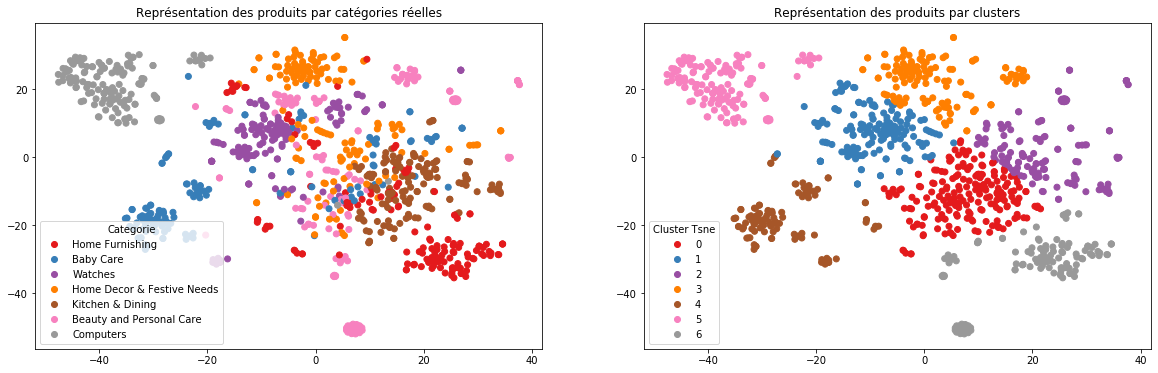

ARI :  0.3589


In [181]:

all_labels=df['target'].unique().tolist()
perplexity=30

n_components=2
ARI, X_tsne, labels =text_utils.ARI_fct(
    bag_of_words_df,
    all_labels,
    df['target'],
    perplexity,
    n_components,
    random_state
  
)

text_utils.TSNE_visu_fct(
    X_tsne, df['target'],df['main_category'].unique().tolist(), labels, ARI,
  'Représentation des produits par catégories réelles',
    'Représentation des produits par clusters'
)

L'indice de rand ajusté (0.35) entre l'ensemble issu de la clusterization tsne et l'ensemble formé par les catégories réelles auxquelles appartiennent les produits, est très faible.
Cependant,on peut remarquer, selon le résultat du tsne, une plus ou moins bonne segmentation des produits de catégorie Computers,Home Furnishing et Baby Care

### 1-3 <u>Essai de classification avec RandomForestClassifier  OneVsRestClassifier</u>

/home/amadou/Desktop/ml/classification_automatique_biens_consommation/functions/text_utils.py:108: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



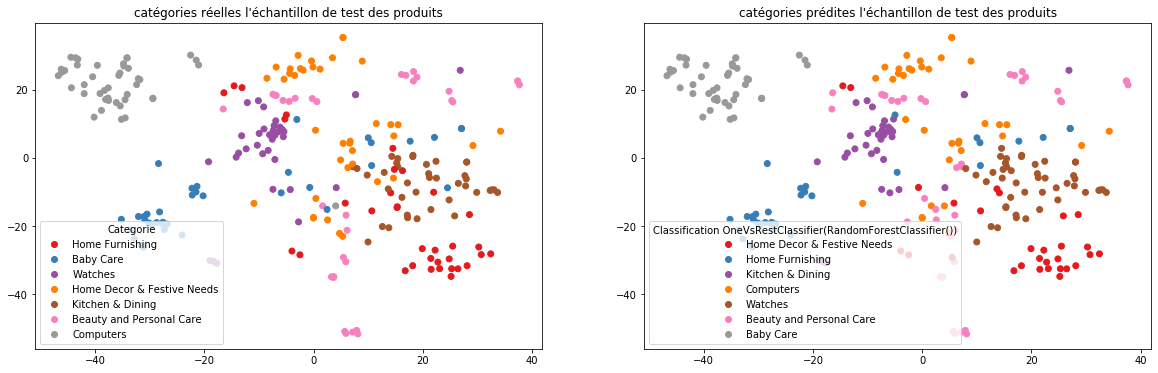

ARI :  0.777
ARI 0.777
mean_auc 0.9762368319596254


In [182]:
X_train,X_test,y_train,y_test=train_test_split(X_tsne,df['target'],test_size=0.25)
scoring='f1_macro'
 

param_grid =[
     { 
   # 'estimator__n_estimators': [100], #[200, 500]
    #'estimator__max_features': ['auto'],#['auto', 'sqrt', 'log2']
    #'estimator__max_depth' : [5],#[4,5,6,7,8]
   'estimator__criterion' :  ['gini', 'entropy'],
         'estimator__random_state':[random_state]
}
]
 
cv=3
model=OneVsRestClassifier(RandomForestClassifier())
mean_auc,ARI,_=classification_utils.grid_search_cv_multiclass(
    model,
    param_grid,
    scoring,
    cv,
    label_target_encoder,
    df['main_category'].unique().tolist(),
    X_train,
    X_test,
    y_train,
    y_test,
'catégories réelles l\'échantillon de test des produits',
  'catégories prédites l\'échantillon de test des produits',
    'Classification OneVsRestClassifier(RandomForestClassifier())'
)


In [183]:
mean_auc

0.9762368319596254

le résultat de la classification, après une réduction dimensionnelle tsne, semble être un bon score(97% la moyenne ).Plus particulièrement pour les produits de catégorie Watches (100% de Area Under the curve)

## 2 <u>TF-IDF</u>

### 1-1 <u>Transformation de la description avec TfidfVectorizer </u>

In [184]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfVectorizer = TfidfVectorizer()

bag_of_words_vec =tfidfVectorizer.fit_transform(df['description_transform_bow_fct'])
bag_of_words_df=pd.DataFrame(bag_of_words_vec.toarray(),columns=tfidfVectorizer.get_feature_names_out())


In [185]:
bag_of_words_df.shape

(1050, 5894)

In [186]:
bag_of_words_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Columns: 5894 entries, 000 to zyxel
dtypes: float64(5894)
memory usage: 47.2 MB


In [187]:
bag_of_words_df.head()

,000,001,0021,004,005,006,0083,011,01433cmgy,01727lpln,...,zinc,zingalalaa,zip,zipexterior,zipper,zippered,zone,zoom,zora,zyxel
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 1-2 <u>Comparaison entre la clusterisation Tsne et les catégories réelles des produits </u>

/home/amadou/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



ARI :  0.4303 time :  5.0


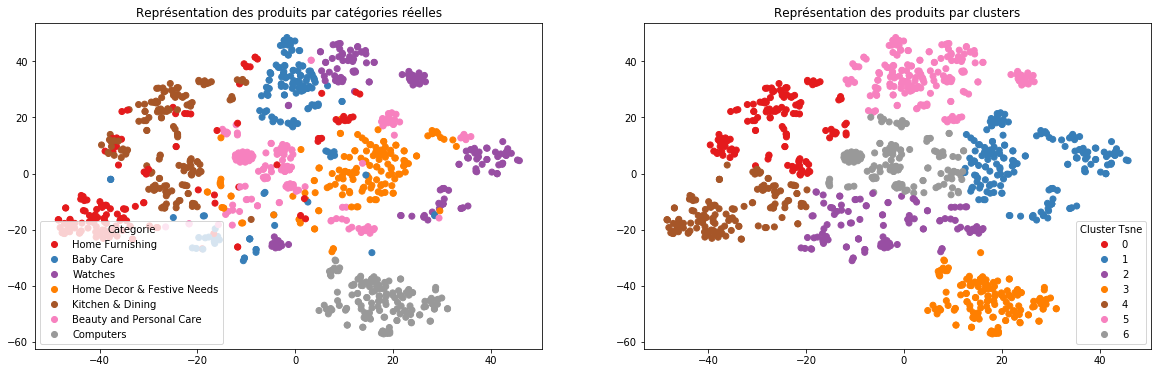

ARI :  0.4303


In [188]:

all_labels=df['target'].unique().tolist()
perplexity=30

n_components=2
ARI, X_tsne, labels =text_utils.ARI_fct(
    bag_of_words_df,
    all_labels,
    df['target'],
    perplexity,
    n_components,
    random_state
  
)

text_utils.TSNE_visu_fct(
    X_tsne, df['target'],df['main_category'].unique().tolist(), labels, ARI,
  'Représentation des produits par catégories réelles',
    'Représentation des produits par clusters'
)

L'indice de rand ajusté (0.50) entre l'ensemble issu de la clusterization tsne et l'ensemble formé par les catégories réelles auxquelles appartiennent les produits, est très faible.
Cependant,on peut remarquer, selon le résultat du tsne, une plus ou moins bonne segmentation des produits de catégorie Computers,Home Furnishing,Home Decors & Festive Needs 

### 1-3 <u>Essai de classification avec RandomForestClassifier  OneVsRestClassifier</u>

/home/amadou/Desktop/ml/classification_automatique_biens_consommation/functions/text_utils.py:108: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



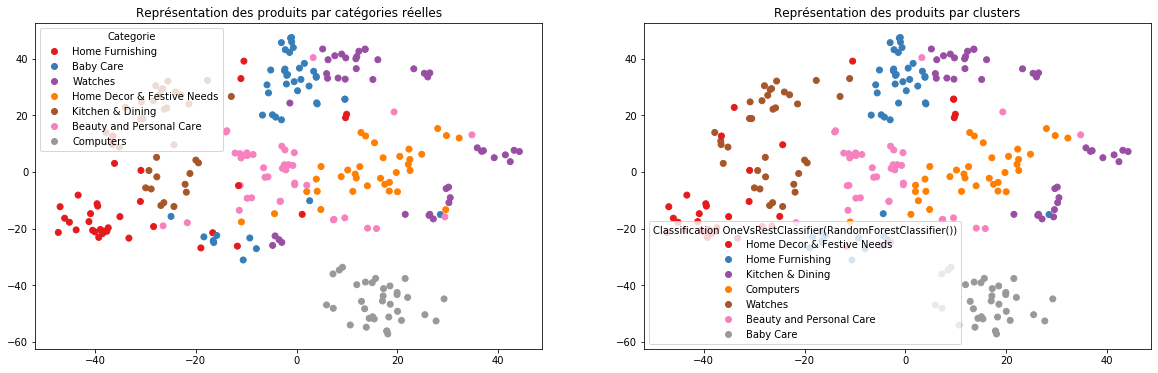

ARI :  0.8253
ARI 0.8253
mean_auc 0.9832322887682198


In [189]:
X_train,X_test,y_train,y_test=train_test_split(X_tsne,df['target'],test_size=0.25)
scoring='f1_macro'
 

param_grid =[
     { 
   # 'estimator__n_estimators': [100], #[200, 500]
    #'estimator__max_features': ['auto'],#['auto', 'sqrt', 'log2']
    #'estimator__max_depth' : [5],#[4,5,6,7,8]
   'estimator__criterion' :  ['gini', 'entropy'],
         'estimator__random_state':[random_state]
}
]
 
cv=3
model=OneVsRestClassifier(RandomForestClassifier())
mean_auc,ARI,_=classification_utils.grid_search_cv_multiclass(
    model,
    param_grid,
    scoring,
    cv,
    label_target_encoder,
    df['main_category'].unique().tolist(),
    X_train,
    X_test,
    y_train,
    y_test,
'Représentation des produits par catégories réelles',
    'Représentation des produits par clusters',
     'Classification OneVsRestClassifier(RandomForestClassifier())'
)


## 3 <u>Word2Vec</u>

### 1-1 <u>Transformation de la description avec gensim.utils </u>

In [190]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim
 

w2v_size=300
w2v_window=5
w2v_min_count=1
w2v_epochs=100
maxlen = 24 # adapt to length of sentences
sentences = df['description_transform_bow_fct'].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]


### 1-2 <u>Comparaison entre la clusterisation Tsne et les catégories réelles des produits </u>


In [191]:
def build_embeddings(sentences ,w2v_size=300,w2v_window=5,w2v_min_count=1,w2v_epochs=100,
maxlen = 24):
        # Création et entraînement du modèle Word2Vec

    print("Build & train Word2Vec model ...")
    w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                                    vector_size=w2v_size,
                                                    seed=42,
                                                    workers=1)
    #                                                workers=multiprocessing.cpu_count())
    w2v_model.build_vocab(sentences)
    w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
    model_vectors = w2v_model.wv
    w2v_words = model_vectors.index_to_key
    print("Vocabulary size: %i" % len(w2v_words))
    print("Word2Vec trained")
    
        # Préparation des sentences (tokenization)

    print("Fit Tokenizer ...")
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(sentences)
    x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                         maxlen=maxlen,
                                                         padding='post') 

    num_words = len(tokenizer.word_index) + 1
    print("Number of unique words: %i" % num_words)
    
        # Création de la matrice d'embedding

    print("Create Embedding matrix ...")
    w2v_size = 300
    word_index = tokenizer.word_index
    vocab_size = len(word_index) + 1
    embedding_matrix = np.zeros((vocab_size, w2v_size))
    i=0
    j=0

    for word, idx in word_index.items():
        i +=1
        if word in w2v_words:
            j +=1
            embedding_vector = model_vectors[word]
            if embedding_vector is not None:
                embedding_matrix[idx] = model_vectors[word]

    word_rate = np.round(j/i,4)
    print("Word embedding rate : ", word_rate)
    print("Embedding matrix: %s" % str(embedding_matrix.shape))
    
        # Création du modèle

    input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
    word_input=Input(shape=(maxlen,),dtype='float64')  
    word_embedding=Embedding(input_dim=vocab_size,
                             output_dim=w2v_size,
                             weights = [embedding_matrix],
                             input_length=maxlen)(word_input)
    word_vec=GlobalAveragePooling1D()(word_embedding)  
    embed_model = Model([word_input],word_vec)

    embed_model.summary()
    
    embeddings = embed_model.predict(x_sentences)
    print('embeddings.shape',embeddings.shape)
    return embeddings
    

 



In [192]:
embeddings=build_embeddings(sentences ,w2v_size,w2v_window,w2v_min_count,w2v_epochs,maxlen )


Build & train Word2Vec model ...
Vocabulary size: 5098
Word2Vec trained
Fit Tokenizer ...
Number of unique words: 5099
Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (5099, 300)
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 24)]              0         
                                                                 
 embedding_3 (Embedding)     (None, 24, 300)           1529700   
                                                                 
 global_average_pooling1d_3   (None, 300)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
Total params: 1,529,700
Trainable params: 1,529,700
Non-trainable params: 0
_________________________________________________________________
33/33 [==============================] - 0s

/home/amadou/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



ARI :  0.2654 time :  4.0


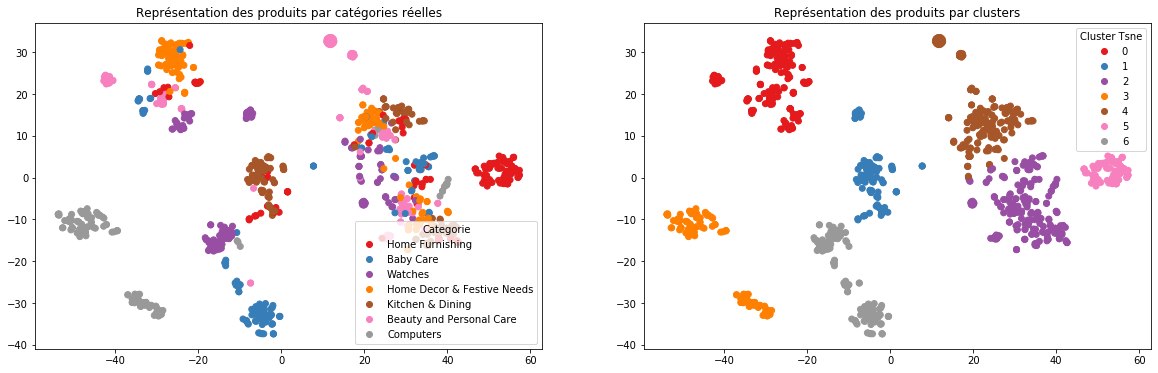

ARI :  0.2654


In [193]:
all_labels=df['target'].unique().tolist()
perplexity=30

n_components=2
ARI, X_tsne, labels =text_utils.ARI_fct(
    embeddings,
    all_labels,
    df['target'],
    perplexity,
    n_components,
    random_state
  
)

text_utils.TSNE_visu_fct(
    X_tsne, df['target'],df['main_category'].unique().tolist(), labels, ARI,
  'Représentation des produits par catégories réelles',
    'Représentation des produits par clusters'
)

### 1-3 <u>Essai de classification avec RandomForestClassifier  OneVsRestClassifier</u>

/home/amadou/Desktop/ml/classification_automatique_biens_consommation/functions/text_utils.py:108: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



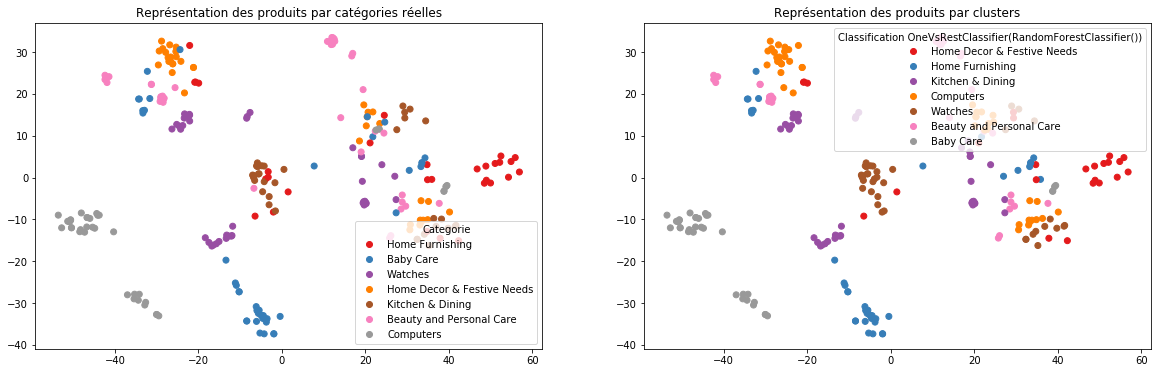

ARI :  0.8121
ARI 0.8121
mean_auc 0.9662180648902022


In [194]:
X_train,X_test,y_train,y_test=train_test_split(X_tsne,df['target'],test_size=0.25)
scoring='f1_macro'
 

param_grid =[
     { 
   # 'estimator__n_estimators': [100], #[200, 500]
    #'estimator__max_features': ['auto'],#['auto', 'sqrt', 'log2']
    #'estimator__max_depth' : [5],#[4,5,6,7,8]
   'estimator__criterion' :  ['gini', 'entropy'],
         'estimator__random_state':[random_state]
}
]
 
cv=3
model=OneVsRestClassifier(RandomForestClassifier())
mean_auc,ARI,_=classification_utils.grid_search_cv_multiclass(
    model,
    param_grid,
    scoring,
    cv,
    label_target_encoder,
    df['main_category'].unique().tolist(),
    X_train,
    X_test,
    y_train,
    y_test,
'Représentation des produits par catégories réelles',
    'Représentation des produits par clusters',
     'Classification OneVsRestClassifier(RandomForestClassifier())'
)


## 4 <u>BERT</u>

### 1-1 <u>Transformation de la description avec TfidfVectorizer </u>

### 1-2 <u>Comparaison entre la clusterisation Tsne et les catégories réelles des produits </u>


### 1-3 <u>Essai de classification avec RandomForestClassifier  OneVsRestClassifier</u>

## 5 <u>USE (Universal Sentence Encoder)</u>

### 1-1 <u>Transformation de la description avec TfidfVectorizer </u>

### 1-2 <u>Comparaison entre la clusterisation Tsne et les catégories réelles des produits </u>

### 1-3 <u>Essai de classification avec RandomForestClassifier  OneVsRestClassifier</u>

# Partie 3: <u>Traitement des images</u>

## 1 <u>Traitement des images avec SIFT</u>

## 1 -1 Rééchantionnagle de la liste des images
* Etant donné qu'on a plusieurs images, et qu'on est dans une étude de faisabilité, traiter toutes les images peut s'avérer couteux et en termes de ressources et mémoire, nous allons opter pour un échantillonage à part égale des catégories de produits selon un pourcentage du dataframe

In [195]:
img_path='data/Flipkart/Images/'
df['img_path']=img_path+df['uniq_id']+'.jpg'

In [196]:
def resampled_df_ (df,col,n):
    df_resampled=pd.DataFrame()
    for item in df[col].unique().tolist():
        df_=df[df[col]==item].head(int(len(df)*(n/100)))
        df_resampled=pd.concat([df_,df_resampled],axis=0)
    return df_resampled.reset_index()

In [197]:
## prise en compte de 0.5% du jeu de données avec équité des catégories de produits
df_resampled=resampled_df_(df,'target',1.5)
df_resampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   index                          105 non-null    int64 
 1   uniq_id                        105 non-null    object
 2   product_category_tree          105 non-null    object
 3   description                    105 non-null    object
 4   product_url                    105 non-null    object
 5   main_category                  105 non-null    object
 6   second_category                105 non-null    object
 7   target                         105 non-null    int64 
 8   description_transform_bow_fct  105 non-null    object
 9   img_path                       105 non-null    object
dtypes: int64(2), object(8)
memory usage: 8.3+ KB


In [198]:
df_resampled.main_category.unique()

array(['Computers', 'Beauty and Personal Care', 'Kitchen & Dining',
       'Home Decor & Festive Needs', 'Watches', 'Baby Care',
       'Home Furnishing'], dtype=object)

In [199]:
df_resampled.main_category.nunique()

7

In [200]:
df_resampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   index                          105 non-null    int64 
 1   uniq_id                        105 non-null    object
 2   product_category_tree          105 non-null    object
 3   description                    105 non-null    object
 4   product_url                    105 non-null    object
 5   main_category                  105 non-null    object
 6   second_category                105 non-null    object
 7   target                         105 non-null    int64 
 8   description_transform_bow_fct  105 non-null    object
 9   img_path                       105 non-null    object
dtypes: int64(2), object(8)
memory usage: 8.3+ KB



## 1 -2 Affichage de l'échantillon d'images par catégorie

In [201]:
from matplotlib.image import imread
import matplotlib.pyplot as plt
def display_images(df_resampled,n):
    for name in df_resampled['main_category'].unique().tolist():
       
        print(name)
        
        images = df_resampled[df_resampled['main_category']==name]['img_path'].head(n).values.tolist()
    
    
    
        for i in range(n):
            plt.subplot(250 + 1 + i)

            image = imread(images[i])
            plt.imshow(image)
        print('----------------------------------------------------')
        plt.show()

Computers
----------------------------------------------------


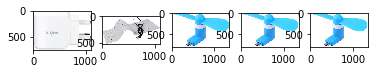

Beauty and Personal Care
----------------------------------------------------


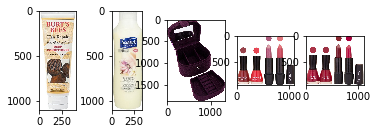

Kitchen & Dining
----------------------------------------------------


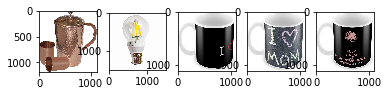

Home Decor & Festive Needs
----------------------------------------------------


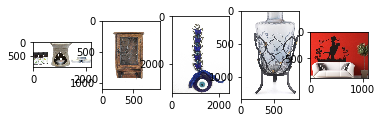

Watches
----------------------------------------------------


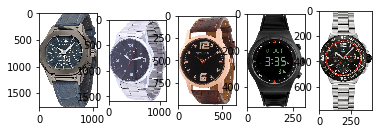

Baby Care
----------------------------------------------------


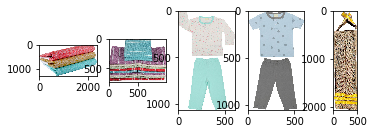

Home Furnishing
----------------------------------------------------


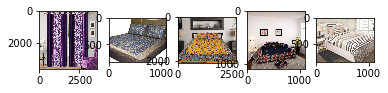

In [202]:
display_images(df_resampled,5)

## 1 -2 Détermination et affichage des descripteurs SIFT d'une image

In [203]:
import cv2



def display_sift_descriptor(image):
    sift = cv2.xfeatures2d.SIFT_create()
    image = cv2.imread(image,0) # convert in gray
    image = cv2.equalizeHist(image)   # equalize image histogram
    kp, des = sift.detectAndCompute(image, None)
    img=cv2.drawKeypoints(image,kp,image)
    plt.imshow(img)
    plt.show()
    print("Descripteurs : ", des.shape)
    print()
    print(des)
    

* L'image contient 16777 descripteurs
* Chaque descripteur est un vecteur de longueur 128

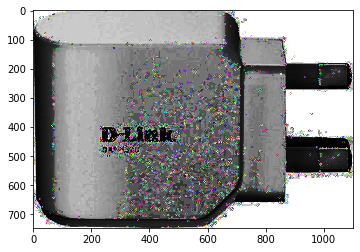

Descripteurs :  (3705, 128)

[[  2.  16.  37. ...   6.   0.   0.]
 [ 20.   3.   2. ...   0.   5.  23.]
 [193.   0.   0. ...   0.   0.   1.]
 ...
 [ 45.  28.   0. ...   0.   0.   0.]
 [  1.   0.   0. ...  34.  23. 100.]
 [ 39.  58.  28. ...   0.   0.   0.]]


In [204]:
image=df_resampled.head(1)['img_path']
display_sift_descriptor(image.values.tolist()[0])

# 1-3 Pré-traitement des images via SIFT


* Pour chaque image passage en gris et equalisation
* création d'une liste de descripteurs par image ("sift_keypoints_by_img") qui sera utilisée pour réaliser les histogrammes par image
* création d'une liste de descripteurs pour l'ensemble des images ("sift_keypoints_all") qui sera utilisé pour créer les clusters de descripteurs

In [205]:
# identification of key points and associated descriptors
import time


def img_descriptors(df_resampled,img_path):
    sift_keypoints = []
    temps1=time.time()
    list_photos=df_resampled[img_path]
    sift = cv2.xfeatures2d.SIFT_create()
    list_photos=df_resampled[img_path].tolist()
    #print('list_photos',list_photos)
    for image_num in range(len(list_photos)) :
        if image_num%100 == 0 : print(image_num)
        image = cv2.imread(list_photos[image_num],0) # convert in gray
        # image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        res = cv2.equalizeHist(image)   # equalize image histogram
        kp, des = sift.detectAndCompute(res, None)
        sift_keypoints.append(des)

    sift_keypoints_by_img = np.asarray(sift_keypoints)
    sift_keypoints_all    = np.concatenate(sift_keypoints_by_img, axis=0)

    print()
    print("Nombre de descripteurs : ", sift_keypoints_all.shape)

    duration1=time.time()-temps1
    print("temps de traitement SIFT descriptor : ", "%15.2f" % duration1, "secondes")
    return sift_keypoints_by_img,sift_keypoints_all
    

In [206]:
sift_keypoints_by_img,sift_keypoints_all=img_descriptors(df_resampled,'img_path')


0
100

Nombre de descripteurs :  (1086995, 128)
temps de traitement SIFT descriptor :            59.55 secondes


/home/amadou/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



## 1-4 Création des clusters de descripteurs


In [207]:
from sklearn.cluster import MiniBatchKMeans



def clusterize_keys_points(sift_keypoints_all):
    k = int(round(np.sqrt(len(sift_keypoints_all)),0))
    temps1=time.time()
    print("Nombre de clusters estimés : ", k)
    print("Création de",k, "clusters de descripteurs ...")
     
    
    # Clustering
    kmeans =MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=random_state)
    kmeans.fit(sift_keypoints_all)
    duration1=time.time()-temps1
    print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")
    return kmeans

In [208]:
kmeans=clusterize_keys_points(sift_keypoints_all)

Nombre de clusters estimés :  1043
Création de 1043 clusters de descripteurs ...
temps de traitement kmeans :            23.10 secondes


## 1-5 Création des features des images
* Pour chaque image : 
   - prédiction des numéros de cluster de chaque descripteur
   - création d'un histogramme = comptage pour chaque numéro de cluster du nombre de descripteurs de l'image

In [209]:


def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


def build_img_features(sift_keypoints_by_img):
    # Creation of histograms (features)
    temps1=time.time()
    # Creation of a matrix of histograms
    hist_vectors=[]

    for i, image_desc in enumerate(sift_keypoints_by_img) :
        if i%100 == 0 : print(i)  
        hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
        hist_vectors.append(hist) #histogram is the feature vector

    im_features = np.asarray(hist_vectors)

    duration1=time.time()-temps1
    print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")
    return im_features



In [210]:
img_features=build_img_features(sift_keypoints_by_img)


0
100
temps de création histogrammes :             3.97 secondes


## 1-6 Réductions de dimension

### Réduction de dimension PCA
* La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99%)
* L'impact est une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE

In [211]:
from sklearn import manifold, decomposition

def pca_reduction(img_features):
    print("Dimensions dataset avant réduction PCA : ", img_features.shape)
    pca = decomposition.PCA(n_components=0.99)
    feat_pca= pca.fit_transform(img_features)
    print("Dimensions dataset après réduction PCA : ", feat_pca.shape)
    return feat_pca

In [212]:
feat_pca=pca_reduction(img_features)

Dimensions dataset avant réduction PCA :  (105, 1043)
Dimensions dataset après réduction PCA :  (105, 75)


### Réduction de dimension T-SNE
* Réduction de dimension en 2 composantes T-SNE pour affichage en 2D des images

In [213]:
from sklearn import manifold

def tsne_reduction(feat_pca,df_resampled,random_state):
    

    tsne = manifold.TSNE(n_components=2, perplexity=30, 
                         random_state=random_state)
    X_tsne = tsne.fit_transform(feat_pca)

    df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
    
    df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
    print('main_category len',len(df_resampled["main_category"]))
    df_tsne["class"] = df_resampled["main_category"]
    print('df_tsne len',len(df_tsne["class"]))
     
    return df_tsne,X_tsne

In [214]:
df_tsne,X_tsne=tsne_reduction(feat_pca,df_resampled,random_state)


/home/amadou/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/home/amadou/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



main_category len 105
df_tsne len 105


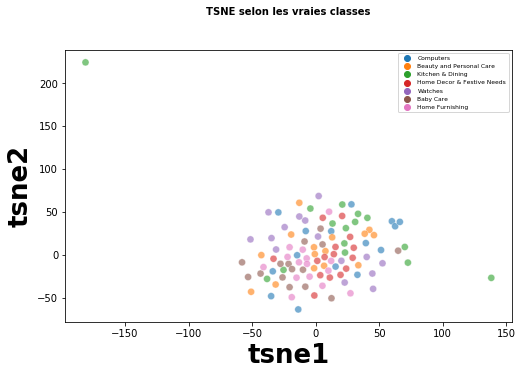

In [215]:
import seaborn as sns
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=df_resampled['main_category'].nunique()), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 10, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 6}) 

plt.show()

## 1-7 Analyse mesures : similarité entre catégories et clusters

###  Création de clusters à partir du T-SNE

In [216]:
from sklearn import cluster

def cluster_tsne(df_tsne,X_tsne,k,random_state):
   cls = cluster.KMeans(n_clusters=k, random_state=random_state)
   cls.fit(X_tsne)
   df_tsne["cluster"] = cls.labels_
   print(df_tsne.shape)
   return df_tsne

In [217]:
df_tsne=cluster_tsne(df_tsne,X_tsne,df['main_category'].nunique(),random_state)

(105, 4)


###  Affichage des images selon clusters et calcul ARI de similarité catégories images / clusters
* Le score ARI de 0.05 reste faible

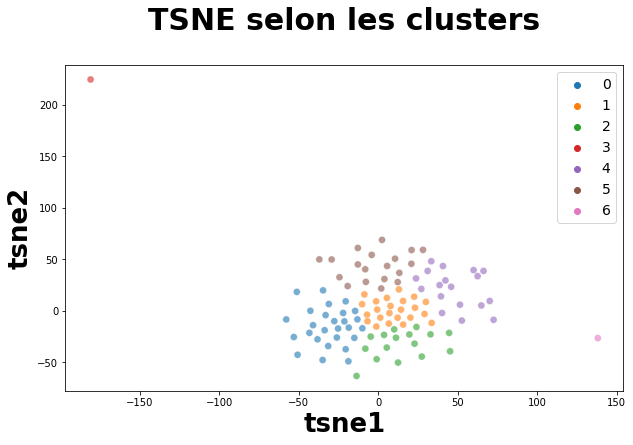

ARI :  0.05320075854646097


In [218]:
from sklearn  import metrics
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=df['main_category'].nunique()), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = df_resampled["target"]
print("ARI : ", metrics.adjusted_rand_score(labels, df_tsne["cluster"] ))

## 2 <u>Transfer learning avec vgg16 extraction de features</u>

## 1-7 Extraction des features 

In [219]:
from keras.layers import  Input
from keras.applications.vgg16 import VGG16
image_input = Input(shape=(224,224,3))
from keras.applications.vgg16 import preprocess_input
model = VGG16(include_top=False,weights="imagenet",input_tensor=image_input)

model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [220]:
from tensorflow.keras.utils import load_img,img_to_array
from keras.applications.vgg16 import preprocess_input
vgg16_feature_list=[]

for img_path in df_resampled['img_path']:

  img = load_img(img_path, target_size=(224, 224))
  img_data = img_to_array(img)
  img_data = np.expand_dims(img_data, axis=0)
  img_data = preprocess_input(img_data)

  vgg16_feature = model.predict(img_data)
  #print('vgg16_feature',vgg16_feature)
  vgg16_feature_np = np.array(vgg16_feature)
  #print('vgg16_feature_np',vgg16_feature_np)
  vgg16_feature_list.append(vgg16_feature_np.flatten())


vgg16_feature_list_np = np.array(vgg16_feature_list)

vgg16_feature_list_np.shape

1/1 [==============================] - 0s 230ms/step


(105, 25088)

In [221]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=df_resampled['main_category'].nunique(), random_state=0).fit(vgg16_feature_list_np)

len(kmeans.labels_)

kmeans.cluster_centers_

kmeans.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 4, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 6,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 2, 2, 2, 5, 1,
       5, 2, 2, 1, 2, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

## 1-8 Classification des images avec vgg16

In [222]:
from keras.applications.vgg16 import VGG16

from tensorflow.keras.utils import load_img,img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions


def classify_img_vgg(model,image_path):
    
    img=load_img(image_path,target_size=(224,224)) ## changer l'image
    img=img_to_array(img)## Convertir en tableau numpy
    img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))  # Créer la collection d'images (un seul échantillon)

    img = preprocess_input(img)  # Prétraiter l'image comme le veut VGG-16
    y = model.predict(img) # prédiction de la classe
    return decode_predictions(y, top=10)[0][1][1]
    

In [223]:
"""
model = VGG16(classifier_activation='softmax') # Création du modèle VGG-16 implementé par Keras

labels = []


for img_path in df['img_path']:
    labels.append(classify_img_vgg(model,img_path))
    
    
    
vgg16_df=pd.DataFrame(data=labels,columns=['label_vgg'])
label_vgg_encoder=LabelEncoder()
vgg16_df['label_vgg_encoded']=label_vgg_encoder.fit_transform(vgg16_df['label_vgg'])
vgg16_df.to_csv('vgg16_classification.csv',index=False)

"""

1/1 [==============================] - 0s 282ms/step


1/1 [==============================] - 0s 276ms/step


1/1 [==============================] - 0s 329ms/step


1/1 [==============================] - 0s 476ms/step


1/1 [==============================] - 0s 270ms/step


/home/amadou/anaconda3/lib/python3.7/site-packages/PIL/Image.py:2766: DecompressionBombWarning:

Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.



1/1 [==============================] - 0s 273ms/step


1/1 [==============================] - 0s 274ms/step


1/1 [==============================] - 0s 283ms/step


In [224]:
vgg16_df = pd.read_csv('vgg16_classification.csv')

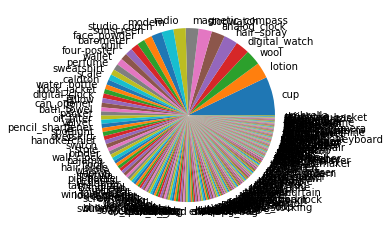

In [225]:
vgg16_df['label_vgg'].value_counts(normalize=True).plot.pie()

In [228]:
vgg16_df['label_vgg_cleaned_txt']=vgg16_df['label_vgg'].apply(lambda x: x.replace("_", " "))
vgg16_df['label_vgg_cleaned_txt']=vgg16_df['label_vgg_cleaned_txt'].apply(lambda x: x.replace("-", " "))
vgg16_df['label_vgg_cleaned_txt']=vgg16_df['label_vgg_cleaned_txt'].apply(lambda x: text_utils.transform_bow_fct(x))

In [232]:
vgg16_df['main_category']=df['main_category']

In [234]:
vgg16_df[vgg16_df['label_vgg']=='cup']

,label_vgg,label_vgg_encoded,label_vgg_cleaned_txt,main_category
44,cup,61,cup,Kitchen & Dining
45,cup,61,cup,Kitchen & Dining
46,cup,61,cup,Kitchen & Dining
48,cup,61,cup,Kitchen & Dining
50,cup,61,cup,Kitchen & Dining
...,...,...,...,...
454,cup,61,cup,Kitchen & Dining
601,cup,61,cup,Kitchen & Dining
994,cup,61,cup,Kitchen & Dining
998,cup,61,cup,Kitchen & Dining


In [230]:
w2v_size=300
w2v_window=5
w2v_min_count=1
w2v_epochs=100
maxlen = 24 # adapt to length of sentences
sentences = vgg16_df['label_vgg_cleaned_txt'].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]


In [231]:
embeddings=build_embeddings(sentences ,w2v_size,w2v_window,w2v_min_count,w2v_epochs,maxlen )

Build & train Word2Vec model ...
Vocabulary size: 303
Word2Vec trained
Fit Tokenizer ...
Number of unique words: 304
Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (304, 300)
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 24)]              0         
                                                                 
 embedding_4 (Embedding)     (None, 24, 300)           91200     
                                                                 
 global_average_pooling1d_4   (None, 300)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
Total params: 91,200
Trainable params: 91,200
Non-trainable params: 0
_________________________________________________________________
33/33 [==============================] - 0s 2ms/step

In [ ]:
kmeans= cluster.KMeans()